# Семинар 3. Диффузионные модели

В данном семинаре мы на простом примере попробуем рассмотреть и реализовать принцип работы дифузных моделей поэтапно.



Основной источник для семинара - это великолепный курс от hugging face, в котором есть дополнительные темы, которые мы не раскроем в данном семинаре: [diffusion-models-class](https://github.com/huggingface/diffusion-models-class)

Другие полезные ссылки:
[Супер теория и use cases](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)

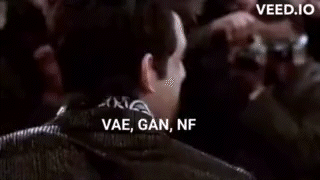

## Рассмотрим:
1. Процесс добавления шума к данным
2. Обучение диффузионной модели
3. Генерацию изображений
4. Сравним нашу диффузию с Denoising Diffusion Probabilistic Models (DDPM)
5. Реализуем Class-Conditioned диффузию

## Устанавливаем зависимости

In [1]:
!pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 9.8 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Данные

Будем использовать данные MNIST. Если ваши глаза больше не могут смотреть на цифры, то можете использовать FashionMNIST, не меняя код.

In [3]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([0, 8, 9, 0, 5, 2, 1, 2])


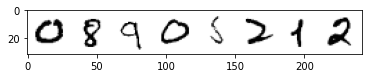

In [4]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

## 1. Процесс добавления шума к данным

Представим, что мы хотим с какой-то долей зашумлять наши данные. В идеале – контролировать этот процесс. Как бы мы это делали? 

Введем переменную `amount`, которая будет отвечать за количество зашумления. Оно будет выглядеть следующим образом:

```
noise = torch.rand_like(x)
noisy_x = (1 - amount) * x + amount * noise
```

Легко заметить, что при `amount=0` никакого зашумления не будет, а при `amount=1` мы полностью зашумим изначальную картинку. Смешивая входные данные с шумом с такими весами, мы сохраняем их в исходном диапазоне – от 0 до 1.




In [5]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount 

Посмотрим на этот процесс постепенного зашумления

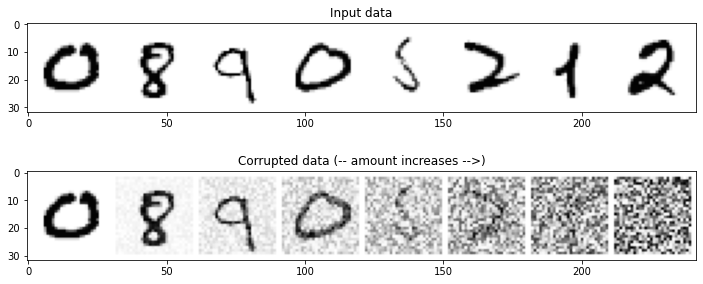

In [6]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plottinf the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

## 2. Обучение диффузионной модели

### Модель

Будем использовать (упрощенную) архитектуру UNet, известную нам с прошлого семестра:

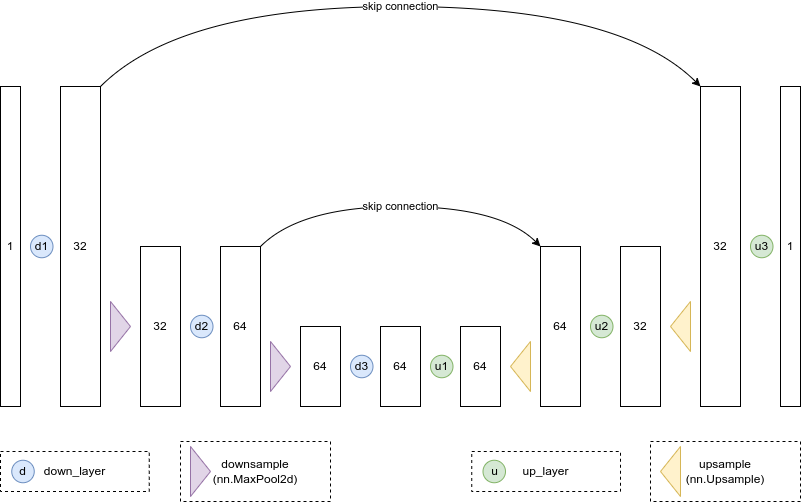

In [7]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([ 
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
        ])
        self.act = nn.SiLU() # activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))              # Through the layer and the activation function
            if i < 2:                       # For all but the third (final) down layer:
              h.append(x)                   # Storing output for skip connection
              x = self.downscale(x)         # Downscale ready for the next layer
              
        for i, l in enumerate(self.up_layers):
            if i > 0:                       # For all except the first up layer
              x = self.upscale(x)           # Upscale
              x += h.pop()                  # Fetching stored output (skip connection)
            x = self.act(l(x))              # Through the layer and the activation function
            
        return x

Проверим наши выходы и количество параметров:

In [8]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [9]:
print(f"Количество параметров в сети: {sum([p.numel() for p in net.parameters()])}")

Количество параметров в сети: 309057


### Обучение


Как будем обучать нашу модель?

Потребуем, чтобы нейронная сеть восстаналивала исходную картинку после зашумления. Сравним полученный результат с исходной картинкой с помощью MSE по пикселям.

Finished epoch 0. Average loss for this epoch: 0.026086
Finished epoch 1. Average loss for this epoch: 0.020093
Finished epoch 2. Average loss for this epoch: 0.018480


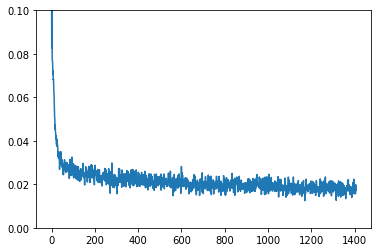

In [10]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = BasicUNet()
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

Давайте посмотрим на то, как модель справляется с шумом:

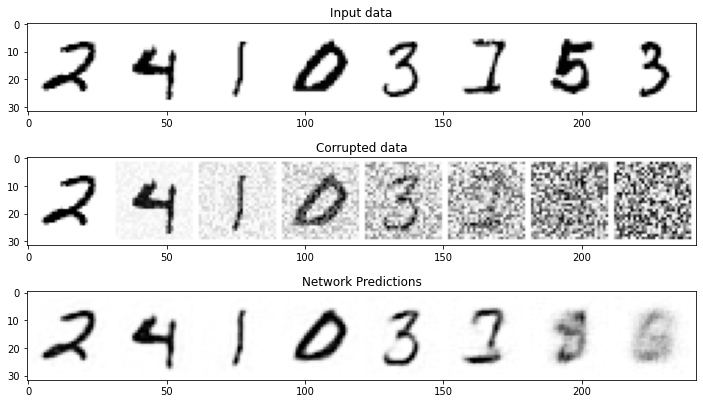

In [11]:
# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

Видим, что модель:
1. Достаточно легко и быстро улавливает основные закономерности и до какого-то момента неплохо денойзит.
2. При большой зашумленности получается что-то непонятное.

## 3. Генерация изображений (sampling)

При сильной зашумленности предсказания модели получились не очень. Что делать в таком случае?я

Мы можем попробовать начать со случайного шума. Смотрим на прогнозы модели, а затем немного продвинемся к этому прогнозу — скажем, на `20%`. Теперь у нас есть очень зашумленное изображение, в котором, возможно, есть намек на структуру. Снова передадим это изображение в модель, чтобы получить новый прогноз. Мы надеемся, что этот новый прогноз немного лучше первого (изображение зашумлено слабее). Делаем еще один небольшой шаг с этим новым, лучшим прогнозом.

Повторяем несколько раз, и (если все пойдет хорошо) мы получим изображение! Ниже запустим этот процесс из 5 шагов. Справа нарисуем входные данные модели.
Слева – прогнозируемые изображения.

Обратите внимание: модель предсказывает изображение с шумоподавлением даже на шаге 1. Но далее мы используем взвешенную сумму исходной зашумленной картинки и предсказания модели. И так на каждом шаге, пока мы не получим окончательные результаты.

**Тезисно:**
* Начинаем со случайного шума
* Несколько раз применяем модель и делаем шаг от исходной картинки в сторону ее предсказаний.
* Удивительно! (или нет) Но прогноз модели на каждом шаге становится более [твердым и четким](https://youtu.be/GkkcRvhEv64).

Процесс из 5 шагов:

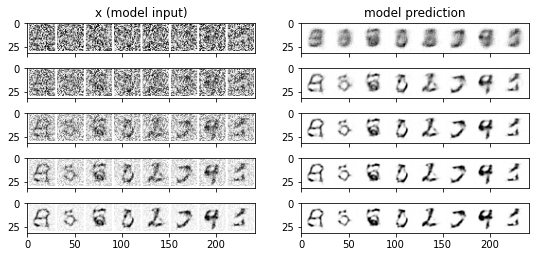

In [12]:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():                             # No need to track gradients during inference
        pred = net(x)                                 # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu())   # Store model output for plotting
    mix_factor = 1 / (n_steps - i)                    # How much we move towards the prediction
    x = x * (1 - mix_factor) + pred * mix_factor      # Move part of the way there
    step_history.append(x.detach().cpu())             # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

Теперь давайте увеличим количество шагов до 40! 
И посмотрим только на генерации:

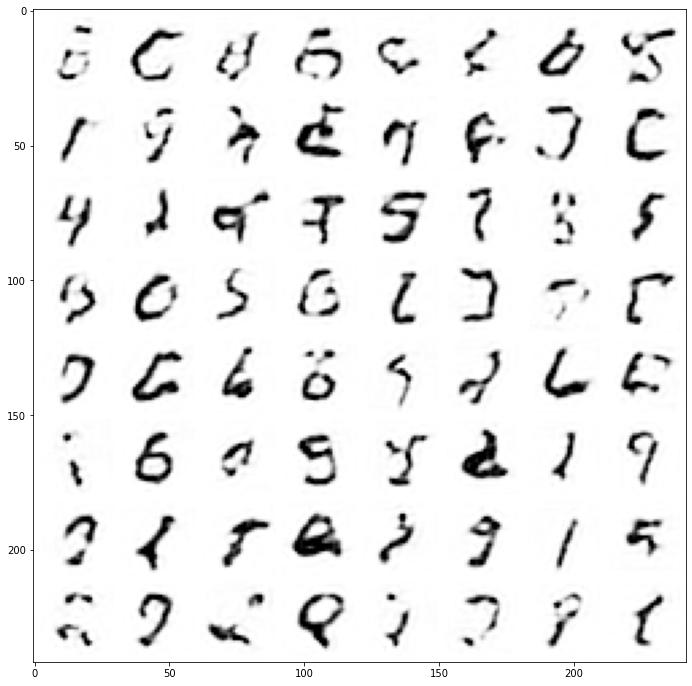

In [13]:
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1 - (i / n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

Когда семинаристы опять пытаются из каракуль доказать, что генерация отличная:
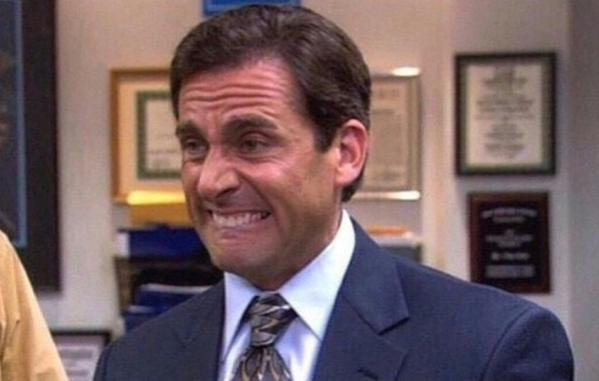

Скажем так. Не прекрасно, но и не ужасно. Особенно если помнить, что мы взяли очень легкую модель + всего пару эпох обучения, которые обучились меньше чем за минуту. Увеличив мощности, можно получить лучшие результаты.

## 4. Сравним нашу модель с Denoising Diffusion Probabilistic Models (DDPM) диффузией

Сравним нашу игрушечную имплементацию с статейной Denoising Diffusion Probabilistic Models (DDPM) ([Introduction to Diffusers](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb)).




*   В статье используется `UNet2DModel`. Она больше и хитрее, чем наша `BasicUNet`
*   По-другому сделан процесс зашумления (corruption process)
* Другая цель обучения: модель прогнозирует сам шум, а не изображение до зашумления.
* В модели есть дополнительный параметр `t` (время), который передается на вход метода `forward`.
* Другие стратегии генерации новых изображений. Они должны работать лучше нашей упрощенной версии.

После выхода статьи о DDPM было предложено несколько улучшений, но мы надеемся, что и этот пример будет достаточно показательным.
Советуем также [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364). В ней подробно рассматриваются идеи из оригинальной статьи и даются новые рекомендации о том, как добиться наилучшей производительности. 

### Модель из статьи

In [14]:
model = UNet2DModel(
    sample_size=28,           # target image resolution
    in_channels=1,            # number of input channels, 3 for RGB images
    out_channels=1,           # number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",        # regular ResNet downsampling block
        "AttnDownBlock2D",    # ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",      # ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # regular ResNet upsampling block
      ),
)
sum([p.numel() for p in model.parameters()]) # 1.7M vs ~309k parameters of the BasicUNet

1707009

Попробуем воспроизвести обучение простой модели из начала семинара, используя модель из статьи вместо нашей исходной. 

На каждом шаге в модель нужно передавать `x`, так и временной шаг. Здесь я всегда передаю `t = 0`, чтобы показать, что она работает и без временного шага. Вы также можете попробовать ввести `(amount * 1000)`.

Finished epoch 0. Average loss for this epoch: 0.019289
Finished epoch 1. Average loss for this epoch: 0.012558
Finished epoch 2. Average loss for this epoch: 0.011488


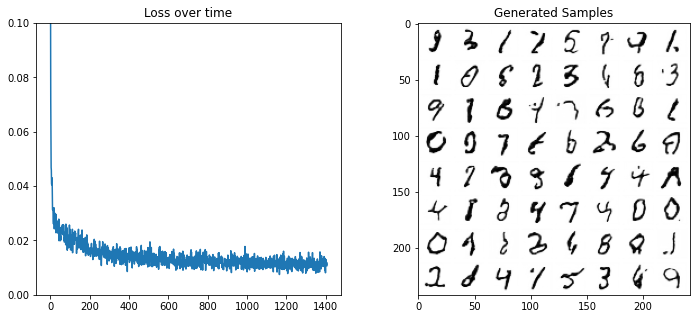

In [15]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=28,                   # target image resolution
    in_channels=1,                    # number of input channels, 3 for RGB images
    out_channels=1,                   # number of output channels
    layers_per_block=2,               # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",                # regular ResNet downsampling block
        "AttnDownBlock2D",            # ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",              # ResNet upsampling block with spatial self-attention
        "UpBlock2D",                  # regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');

Судя по лоссу, архитектура из статьи гораздо лучше справляется с расшумлением изображений!

In [16]:
from IPython.display import Image
Image(url='https://i.kym-cdn.com/photos/images/original/002/036/007/9bd.gif')

## Отступление. Несколько моментов по статье

### Процесс зашумления (The Corruption Process)

В статье DDPM описывается процесс зашумления, который добавляет небольшое количество шума для каждого «временного шага». Имя $x_{t-1}$ для некоторого временного шага $t$, мы можем получить следующую (чуть более шумную) версию $x_t$ как:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x} _{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t -1})$<br><br>


Иными словами, мы берем $x_{t-1}$, масштабируем его на $\sqrt{1 - \beta_t}$ и добавляем шум, масштабированный на $\beta_t$. Эта $\beta_t$ определяется для каждого $t$ в соответствии с некоторым расписанием (scheduler). Она определяет, сколько шума добавляется за каждый временной шаг.

Нам не нужно выполнять эту операцию 500 раз, чтобы получить $x_{500}$, потому что у нас есть другая формула для получения $x_t$ для любого заданного $t$ и $x_0$: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, \sqrt{(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$, где $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ и $\alpha_i = 1-\beta_i$<br><br>

Выглядит страшно! К счастью, планировщик обрабатывает все это за нас:

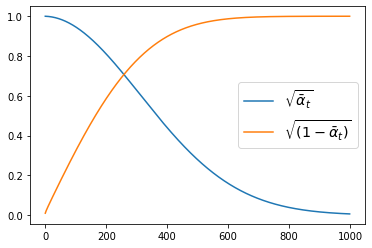

In [17]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000) # Задаем наш scheduler
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Сначала зашумленный $x$ в основном равен $x \sqrt{\overline \alpha_t} \approx x$. Но со временем вклад $x$ падает, а шумовая составляющая увеличивается. В отличие от способа зашумления из начала семинара (функция `corrupt`), тут картинка зашумляется относительно быстро.

Выглядит это вот так:

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


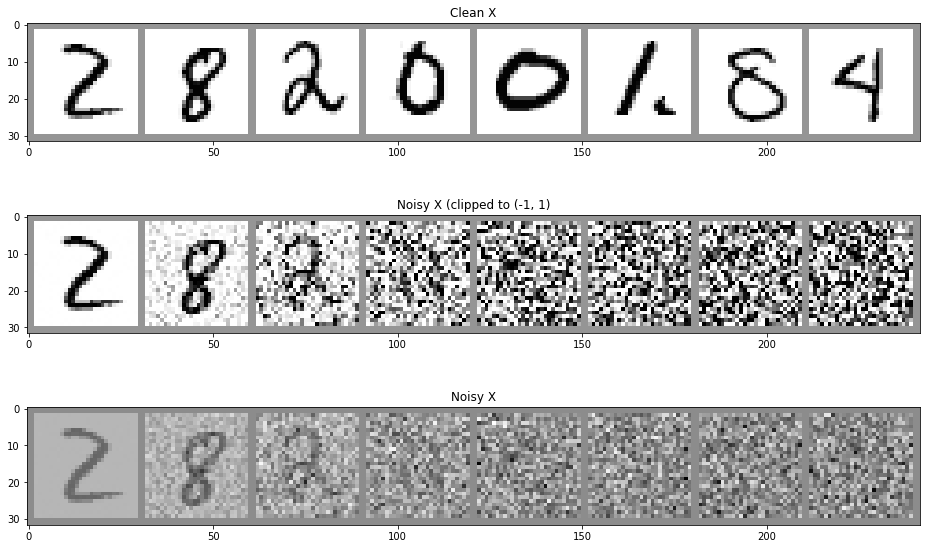

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1. # Map to (-1, 1)
print('X shape', xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),  cmap='Greys')
axs[2].set_title('Noisy X');

Кроме того, DDPM добавляет шум, взятый из распределения Гаусса (среднее значение 0, стандартное отклонение 1 из `torch.randn`). Ранее мы использовали равномерный шум между 0 и 1 (из `torch.rand`). В общем случае имеет смысл нормализовать и обучающие данные.

### Обучение

В нашем игрушечном примере модель пыталась предсказать изображение без шума. В DDPM и во многих других реализациях диффузионной модели нейросеть предсказывает шум, используемый в процессе искажения. В коде это выглядит примерно так:

```python
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
model_prediction = model(noisy_x, timesteps).sample
loss = mse_loss(model_prediction, noise) # noise as the target
```

Вы можете подумать, что прогнозирование шума (из которого мы можем вывести, как выглядит изображение с шумоподавлением) эквивалентно простому прогнозированию изображения с шумоподавлением напрямую. **Так зачем отдавать предпочтение одному перед другим — для математического удобства?**

Мы вычисляем потери на разных (случайно выбранных) временных шагах во время обучения. Эти разные цели приведут к различному «неявному взвешиванию» потерь, когда прогнозирование шума придает больший вес более низким уровням шума. Вы можете выбрать более сложные цели, чтобы изменить это «неявное взвешивание потерь». Или, возможно, вы выберете график шума, который приведет к большему количеству примеров с более высоким уровнем шума.

На данный момент прогнозирование шума является предпочтительным подходом. Но со временем мы, вероятно, увидим другие цели, поддерживаемые в библиотеке и используемые в различных ситуациях.


### Временной шаг (timestamp conditioning)

`UNet2DModel` принимает не только $x$, так и временной шаг $t$ (эмбеддинг). Таким образом мы передаем модели **информацию об уровне шума**, который необходимо спрогнозировать. На ранних этапах этого шума в изображении меньше, на поздних – больше. Это позволяет нейросети лучше выполнить свою задачу.

Несмотря на то, что можно обучить модель и без информации о времени, в некоторых случаях это помогает повысить производительность. Большинство реализаций используют время, по крайней мере, сегодня.

## 5. Реализуем Class-Conditioned диффузию

In [19]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()
    
    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64), 
        down_block_types=( 
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ), 
        up_block_types=(
            "AttnUpBlock2D", 
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape
    
    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dinemsion
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the unet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [20]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

100%|██████████| 469/469 [01:47<00:00,  4.35it/s]


Finished epoch 0. Average of the last 100 loss values: 0.053150


100%|██████████| 469/469 [01:49<00:00,  4.28it/s]


Finished epoch 1. Average of the last 100 loss values: 0.046996


100%|██████████| 469/469 [01:50<00:00,  4.23it/s]


Finished epoch 2. Average of the last 100 loss values: 0.043577


100%|██████████| 469/469 [01:51<00:00,  4.20it/s]


Finished epoch 3. Average of the last 100 loss values: 0.042573


100%|██████████| 469/469 [01:51<00:00,  4.20it/s]


Finished epoch 4. Average of the last 100 loss values: 0.041353


100%|██████████| 469/469 [01:51<00:00,  4.19it/s]


Finished epoch 5. Average of the last 100 loss values: 0.040798


100%|██████████| 469/469 [01:51<00:00,  4.20it/s]


Finished epoch 6. Average of the last 100 loss values: 0.040243


100%|██████████| 469/469 [01:51<00:00,  4.19it/s]


Finished epoch 7. Average of the last 100 loss values: 0.038994


100%|██████████| 469/469 [01:51<00:00,  4.20it/s]


Finished epoch 8. Average of the last 100 loss values: 0.039703


100%|██████████| 469/469 [01:52<00:00,  4.19it/s]


Finished epoch 9. Average of the last 100 loss values: 0.039268


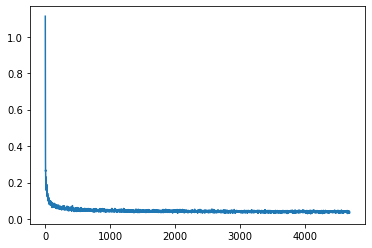

In [21]:
from tqdm import tqdm
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our network 
net = ClassConditionedUnet().to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        
        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

1000it [00:43, 23.24it/s]


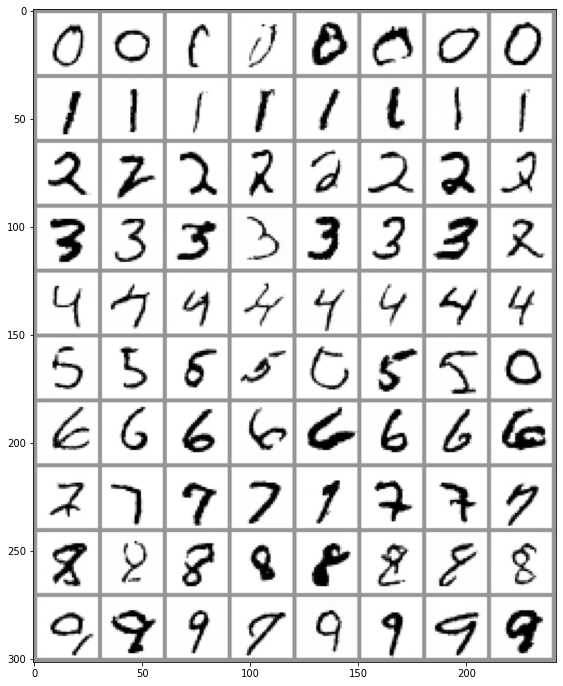

In [22]:
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = net(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')

Теперь вся власть в наших руках и мы можем заставить модель генерировать цифру, которую мы хотим!

In [23]:
Image(url='https://media.tenor.com/Vr5oMNMnNJIAAAAS/vince-vince-mcmahon.gif')